In [1]:
# Import statements
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import openpyxl
import pylab as plt
import glob
import os

import nltk

plt.rcParams["font.size"] = 16

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.pipeline import make_pipeline
from wordcloud import WordCloud
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

from sentence_transformers import SentenceTransformer
import torch

import regex as re
import pandas as pd
from bs4 import BeautifulSoup

import io

import requests
from pypdf import PdfReader

# UBC Salaries Across Gender, Department, and Job Title

## Introduction

The primary objective of this project is to develop skills in data wrangling, machine learning, and Tableau. A secondary goal is to create a Tableau dashboard for visualizing University of British Columbia (UBC) faculty salaries based on gender, department, and job title.

To prioritize learning, rather than directly requesting salary data from UBC by department, job title, and gender, I will rely on the annual PDF of salary data released by UBC, along with information from UBC's faculty directory and global baby name datasets.

The project involves several steps: gathering and cleaning salary data, collecting and cleaning department and job title data, making gender predictions for each faculty member, and ultimately visualizing the cleaned data through a Tableau dashboard.

This approach incorporates tasks such as scraping, clustering, and data transformation, offering an in-depth exploration of data manipulation techniques and fostering a comprehensive understanding of the intricacies involved in data wrangling.

## Contents

The following list is how the rest of this project will unfold:

- Data Collection and Cleaning
    - Salary Data
    - Department and Job Title Data
- Gender Prediction
- Data Visualization
- Conclusion

## Data Collection and Cleaning

### Salary Data

We can use the PDF salary information that UBC releases every year. The salary information is retrieved from the following website: [UBC Financial Reports](https://finance.ubc.ca/reporting-planning-analysis/financial-reports). The first step is to go to this website and find the links for years with available salary data.

In [2]:
links = {} # get all financial report links
r = requests.get('https://finance.ubc.ca/reporting-planning-analysis/financial-reports') # go to financial report webpage
soup = BeautifulSoup(r.content, 'html.parser')
finance_section = soup.find('h3', string = re.compile('Financial Information Act')) # find the "Financial Information Act" header
salary_link_elements = finance_section.find_next_sibling('ul').findAll('li') # find the section with the links
for element in salary_link_elements: # collect all of the links
    salary_link = element.find('a').get('href') # get link from element
    year = "20" + re.search("FY([0-9][0-9])", salary_link).group(1) # use regex to get the year in each link
    links[year] = salary_link # add year and link to dictionary 
links

{'2023': 'https://finance.ubc.ca/sites/finserv.ubc.ca/files/FY23%20UBC%20Statement%20of%20Financial%20Information.pdf',
 '2022': 'https://finance.ubc.ca/sites/finserv.ubc.ca/files/FY22%20UBC%20Statement%20of%20Financial%20Information.pdf',
 '2021': 'https://finance.ubc.ca/sites/finserv.ubc.ca/files/FY21%20UBC%20Statement%20of%20Financial%20Information.pdf',
 '2020': 'https://finance.ubc.ca/sites/finserv.ubc.ca/files/FY20_Financial_Information_Act_Report.pdf'}

Above we can see the years with available salary information.

Next, I will create a function that when given a link, will return the text from the link in string form.

In [3]:
def fetch_salary_data(link):
    '''find UBC salary pdf for given year and return it in string form'''
    url = link
    
    r = requests.get(url)
    f = io.BytesIO(r.content)
    
    all_text = "" # variable to store all text in pdf
    reader = PdfReader(f)
    contents = reader.pages # returns a list of pages
    for content in contents: # for each page, extract text
        all_text += content.extract_text() # add text to all_text
        
    return all_text

Now, I will create a function that can take the salary data in string form, clean it up, and return a dataframe with the columns: `First Name`, `Last Name`, `Remuneration`, `Expenses`, and `Year`.

In [4]:
def clean_salary_data(raw_data, year):
    '''take salary data in string form and turn it into a dataframe, add a column and fill it with the given year'''
    # Remove beginning/end text
    raw_data_a = raw_data.split('Earnings greater than')[0].split('external cost recoveries.')[1]
    raw_data_a
    
    # Remove unnessessary lines
    raw_data_b = re.split('([\.\p{L},\s-]+[\s\n]+[0-9,-]+[\s\n]+[0-9,-]+)', raw_data_a)
    
    raw_data_c = [i for i in raw_data_b if (',' in i) and ('SCHEDULE' not in i)]
    
    # Remove spaces and new lines
    raw_data_d = [i.replace('\n',' ').replace("  "," ").strip() for i in raw_data_c]
    raw_data_d = [i.replace("  "," ") for i in raw_data_d]
    
    # # Split data into Names/Remuneration/Expenses
    raw_data_e = [i.rsplit(' ',2) for i in raw_data_d]
    raw_data_e
    
    # Create Column names
    ubc_salary_data = pd.DataFrame(raw_data_e, columns = ['Name', 'Remuneration', 'Expenses'])
    
    # Split Name into First/Last Name
    ubc_salary_data['First Name'] = ubc_salary_data['Name'].str.split(', ', expand = True)[1]
    ubc_salary_data['Last Name'] = ubc_salary_data['Name'].str.split(', ', expand = True)[0]
    
    
    # Select necessary columns
    ubc_salary_data = ubc_salary_data[['Last Name','First Name','Remuneration','Expenses']]
    
    # turn salary column from string to numeric
    ubc_salary_data['Remuneration'] = ubc_salary_data['Remuneration'].astype(str).str.replace(',','')
    ubc_salary_data['Remuneration'] = pd.to_numeric(ubc_salary_data['Remuneration'], errors='coerce')

    ubc_salary_data['Year'] = f"{year}"

    return ubc_salary_data

Now I will loop through the salary data links I collected, clean up the data for each year, and combine the data into one dataframe. 

In [5]:
salary_data = pd.DataFrame(columns = ['Last Name', 'First Name', 'Remuneration', 'Expenses','Year']) # create empty dataframe for salary data
most_recent = True # keeps track of most recent salary data
for year, link in links.items(): # for each year that UBC has data for
    raw = fetch_salary_data(link) # get raw data in string form
    salaries = clean_salary_data(raw, year) # get clean data as a dataframe
    if most_recent: # export the most recent salary data so that we can collect the new department/job title info
        salaries.to_csv(f"/Users/jadebouchard/Desktop/UBC Salaries/Salary Data/{year}.csv")
        most_recent = False
    if salary_data.empty: # avoid warning that we shouldn't be concatenating empty dataframes
        salary_data = salaries
    else:
        salary_data = pd.concat([salary_data,salaries]) # paste dataframes together

Below you can see a recent and less recent section of the data.

In [6]:
salary_data.head()

,Last Name,First Name,Remuneration,Expenses,Year
0,Aamodt,Tor,193153.0,"5,597",2023
1,Abanto Salguero,Arleni Karina,107723.0,393,2023
2,Abbassi,Arash,109136.0,82,2023
3,Abdalkhani,Arman,101829.0,-,2023
4,Abdi,Ali,238203.0,"2,981",2023


In [7]:
salary_data.tail()

,Last Name,First Name,Remuneration,Expenses,Year
6219,Zumbo,Bruno,294953.0,"10,102",2020
6220,Zumpano,Franco,94463.0,420,2020
6221,Zumrawi,Abdel Azim,98145.0,-,2020
6222,Zwicker,Jill,145343.0,"12,523",2020
6223,Zysk,Eva,93058.0,"2,489",2020


This scraping process missed about 70 entries due to formatting issues. These entries will be removed going forward.

In [8]:
salary_data = salary_data[~salary_data.isnull().any(axis = 1)]

Also, now that the department and title data has been merged onto the salary data, to try and maintain consistency over the years names will be shortened. For example, "A Bobby" will be shortened to "Bobby" and "Anne Michele" will be shortened to "Anne".

In [9]:
def shorten_name(name):
    '''remove initials from names, and if two names just keep the first one'''
    name = name.strip() # remove white space
    name = name.replace(" -","-").replace("- ","-") # make sure names that should be connected are connected
    if len(name.split(" ")) <= 1: # if only one word, return word
        return name
    else:
        words = name.split(" ")
        for word in words: # remove initials if they exist
            if len(word) == 1:
                words.remove(word)
        return words[0] # return first word

salary_data.loc[:,"First Name"] = salary_data["First Name"].apply(shorten_name)
salary_data.loc[:,"Last Name"] = salary_data["Last Name"].apply(shorten_name)

Finally, I will add columns that show the salary difference in dollar amount and percentage compared to the previous year.

In [10]:
salary_data['Year'] = salary_data['Year'].apply(int) # change year column to integer
salary_data['Last Year'] = salary_data['Year'] - 1 # find previous year for each row
original_df = salary_data.copy() # create a new variable to represent salary data

In [11]:
# perform a self-merge to get the salary information for the previous year
salary_data = original_df.merge(original_df[['Last Name','First Name','Year','Remuneration']], how='left', left_on=['Last Name','First Name','Last Year'], right_on=['Last Name','First Name','Year'])

In [12]:
# create new columns to represent salary increase/decrease in dollar amount and another column for percentage
salary_data['Remuneration_Difference_Dollar'] = (salary_data['Remuneration_x'] - salary_data['Remuneration_y'])
salary_data['Remuneration_Difference_Percent'] = round((salary_data['Remuneration_x'] - salary_data['Remuneration_y'])/salary_data['Remuneration_x']*100,2)

In [13]:
# remove unnecessary columns
salary_data = salary_data.drop(columns = ['Last Year', 'Year_y', 'Remuneration_y'])
salary_data = salary_data.rename(columns = {"Year_x":"Year","Remuneration_x":"Remuneration"})

In [78]:
salary_data[salary_data['Last Name'] == "Nunn"]

,Last Name,First Name,Remuneration,Expenses,Year,Remuneration_Difference_Dollar,Remuneration_Difference_Percent
5137,Nunn,Nathan,444505.0,"4,784",2023,271195.0,61.01
12738,Nunn,Nathan,173310.0,38,2022,NaN,NaN


Now we have clean salary data for UBC staff members. I will export this data so that it is available for anyone to use.

In [14]:
salary_data.to_excel('data/UBC_Salary_DF_All_Years.xlsx', index = False)
salary_data.to_csv('data/UBC_Salary_DF_All_Years.csv', index = False, encoding = "utf8")

### Department and Job Title Data

#### Collection

After collecting the salary data, I retrieved department and job title information for each UBC staff member from the following [website](https://directory.ubc.ca/index.cfm). To gather the data I used Python's requests package. The code and entirety of the raw data will not be provided here because I'm not allowed to publicly distribute all of this data. 

Below I will combine the department and job title I have gathered over the years, and merge it onto the salary dataset. An **important note** is that I don't have department or job title information for 2020, 2021, and 2022. For these years I'm going to fill them in with 2023 data.

In [15]:
# Retrieving 2023 data
department_data = pd.read_excel("/Users/jadebouchard/Desktop/UBC Salaries/Department Data/UBC_Salary_Department_2023.xlsx")

In [16]:
# Creating department and job title info for 2020, 2021, and 2022 using 2023 data.
for year in ['2020','2021','2022']:
    department_data['Year'] = year
    department_data.to_excel(f"/Users/jadebouchard/Desktop/UBC Salaries/Department Data/UBC_Salary_Department_{year}.xlsx", index = False)

In [17]:
# Combining job title and department data across all years

# note: when I say department data, I mean department and job title data

# path to scraped department data
department_path = r'/Users/jadebouchard/Desktop/UBC Salaries/Department Data' 

# collect department data file paths for each year
all_department_files = glob.glob(os.path.join(department_path, "*.xlsx"))

# collect dataframes for each year of scraped department data
department_dataframes = []

for filename in all_department_files:
    df = pd.read_excel(filename, index_col=None, header=0)
    department_dataframes.append(df)

# merge department dataframes together
pop_df = pd.concat(department_dataframes, axis=0).drop_duplicates()[['Last Name',"First Name","Department","Title","Year"]]

In [18]:
# drop any duplicates and convert year to string
pop_df = pd.concat(department_dataframes, axis=0).drop_duplicates()
pop_df['Year'] = pop_df['Year'].apply(str)

In [19]:
# drop any index columns
pop_df = pop_df[pop_df.columns.drop(list(pop_df.filter(regex='Unnamed')))]
pop_df.head()

,Last Name,First Name,Remuneration,Expenses,Department,Title,Year
0,Aamodt,Tor,193153.0,"5,597",Electrical and Computer Engineering,Professor,2020
1,Abanto Salguero,Arleni Karina,107723.0,393,NaN,NaN,2020
2,Abbassi,Arash,109136.0,82,"Office of the Vice-President, Academic","Intern, Strategy and Decision Support",2020
3,Abdalkhani,Arman,101829.0,-,"Surgery, Faculty of Medicine - Vancouver Coast...","Clinical Instructor, Otolaryngology - Head and...",2020
4,Abdi,Ali,238203.0,"2,981",Educational Studies (EDST),Professor,2020


We now have retrieved (or invented) job title and department data for 2020 onwards.

Now, for some additional data clean-up.

In [20]:
# Removes a small number of observations that weren't formatted correctly
pop_df = pop_df[~pop_df.isnull().any(axis = 1)]

In [21]:
# shorten names so that merge with salary data works
pop_df.loc[:,"First Name"] = pop_df["First Name"].apply(shorten_name)
pop_df.loc[:,"Last Name"] = pop_df["Last Name"].apply(shorten_name)

The next step is to combine the department data with the salary data collected earlier.

In [22]:
salary_data.head()

,Last Name,First Name,Remuneration,Expenses,Year,Remuneration_Difference_Dollar,Remuneration_Difference_Percent
0,Aamodt,Tor,193153.0,"5,597",2023,-28738.0,-14.88
1,Abanto,Arleni,107723.0,393,2023,7109.0,6.60
2,Abbassi,Arash,109136.0,82,2023,1847.0,1.69
3,Abdalkhani,Arman,101829.0,-,2023,26510.0,26.03
4,Abdi,Ali,238203.0,"2,981",2023,-3763.0,-1.58


In [23]:
# Merging department info onto all salary data - all job titles/departments are from data collected in 2023
salary_data["Year"] = salary_data["Year"].apply(str) # change year column to type string for merge
pop_df_dep = pd.merge(salary_data, pop_df[["First Name","Last Name",'Department','Title',"Year"]], how = "left", on = ["First Name","Last Name","Year"])

In [24]:
pop_df_dep.head()

,Last Name,First Name,Remuneration,Expenses,Year,Remuneration_Difference_Dollar,Remuneration_Difference_Percent,Department,Title
0,Aamodt,Tor,193153.0,"5,597",2023,-28738.0,-14.88,Electrical and Computer Engineering,Professor
1,Abanto,Arleni,107723.0,393,2023,7109.0,6.60,NaN,NaN
2,Abbassi,Arash,109136.0,82,2023,1847.0,1.69,"Office of the Vice-President, Academic","Intern, Strategy and Decision Support"
3,Abdalkhani,Arman,101829.0,-,2023,26510.0,26.03,"Surgery, Faculty of Medicine - Vancouver Coast...","Clinical Instructor, Otolaryngology - Head and..."
4,Abdi,Ali,238203.0,"2,981",2023,-3763.0,-1.58,Educational Studies (EDST),Professor


In [25]:
# Remove people with the same first name and last name since I cannot tell them apart
pop_df_dep = pop_df_dep.drop_duplicates(subset=['First Name','Last Name','Year'], keep = False)

#### Cleaning

To make the data processing step work smoothly, I will convert the department and job title columns to a string format.

In [26]:
pop_df_dep["Department"] = pop_df_dep["Department"].apply(str)
pop_df_dep["Title"] = pop_df_dep["Title"].apply(str)
pop_df_dep.head()

,Last Name,First Name,Remuneration,Expenses,Year,Remuneration_Difference_Dollar,Remuneration_Difference_Percent,Department,Title
0,Aamodt,Tor,193153.0,"5,597",2023,-28738.0,-14.88,Electrical and Computer Engineering,Professor
1,Abanto,Arleni,107723.0,393,2023,7109.0,6.60,nan,nan
2,Abbassi,Arash,109136.0,82,2023,1847.0,1.69,"Office of the Vice-President, Academic","Intern, Strategy and Decision Support"
3,Abdalkhani,Arman,101829.0,-,2023,26510.0,26.03,"Surgery, Faculty of Medicine - Vancouver Coast...","Clinical Instructor, Otolaryngology - Head and..."
4,Abdi,Ali,238203.0,"2,981",2023,-3763.0,-1.58,Educational Studies (EDST),Professor


In [27]:
pop_df_dep['Department'].nunique()

545

In [28]:
pop_df_dep['Title'].nunique()

2976

Now, I will correct any incorrect data that I am aware of.

In [29]:
# David Patrick was listed as a prof in the computer science faculty since there is someone with a similar name in that faculty. 
# based on the salary value this david patrick should be in the medicine faculty
pop_df_dep.loc[(pop_df_dep['First Name'] == "David") & (pop_df_dep['Last Name'] == "Patrick"),'Department'] = "Centre for Disease Control"
pop_df_dep.loc[(pop_df_dep['First Name'] == "David") & (pop_df_dep['Last Name'] == "Patrick"),'Title'] = "Executive Medical Director and Deputy Provincial Health Officer Professor, School of Population and Public Health"

Now, the department and title information is separated. However, there are so many unique values that it will make data analysis difficult and ineffective. Therefore, I will group together similar department data and title data.

#### Grouping Data

For clustering Department I used the DBScan clustering method. I chose this method over KMeans as it allows for points to not have an assigned Department. It also lets me avoid choosing the number of groups beforehand. I chose a fairly conservative eps value (0.25) as it's important that points don't get miss-classified.

The first step is to do some preprocessing. I will remove some words and symbols from the department column that I don't want the algorithm using to determine similarity.

In [30]:
# Removing some words and symbols from the department text as it confuses the cluster algorithm
pop_df_dep["Department - short"] = pop_df_dep["Department"].replace({"Faculty of ":"",
                                                             "Faculty":"",
                                                             "IKBFoS":"", "IKBFASS":"", 
                                                             "–":"", "-":"", "Department":"", "School":"",
                                                             "Office":"","Institute":"",
                                                             f"\n":"",
                                                             'Centre':""}, regex=True)

I'm also choosing to remove Location info about university, although it would be interesting to look at salary disparity across location another time

In [31]:
pop_df_dep["Department - short"] = pop_df_dep["Department - short"].replace({"UBC Okanagan":""}, regex=True)

In [32]:
pop_df_dep = pop_df_dep.reset_index(drop=True) # reset index so embedder works

The next step is to train the clustering model.

In [33]:
embedder = SentenceTransformer("paraphrase-distilroberta-base-v1")

In [34]:
emb_department = embedder.encode(pop_df_dep['Department - short'])

In [35]:
emb_department_df = pd.DataFrame(emb_department, index=pop_df_dep.index)

In [36]:
# relate min_samples to the amount of data collected in links
dbscan = DBSCAN(eps=0.2, min_samples = 15*len(links),metric='cosine')
dbscan.fit(emb_department_df)

DBSCAN(eps=0.2, metric='cosine', min_samples=60)

Now that we have our model fitted, we can analyze its performance. To do this, I create and examine a silhouette plot. 

In [37]:
n_clusters = len(set(dbscan.labels_))
dbscan.n_clusters = n_clusters
dbscan.predict = lambda x: dbscan.labels_

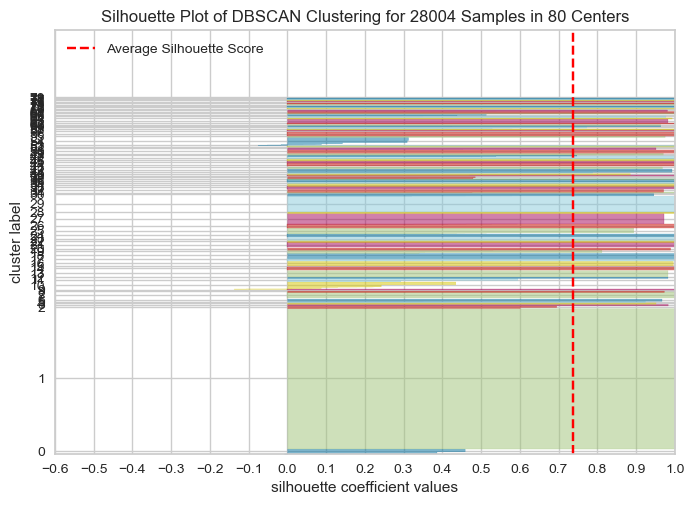

<Axes: title={'center': 'Silhouette Plot of DBSCAN Clustering for 28004 Samples in 80 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [38]:
visualizer = SilhouetteVisualizer(dbscan, colors="yellowbrick")
visualizer.fit(emb_department)  
visualizer.show()

From the above silhouette plot, I can see that that the chosen eps and min_sample values do a pretty good job of seperating the data into distinct clusters. 

One item of note is that the 1 cluster (data points with a null Department value) makes up about 35% of the data. This informs us that many observations do not have an associated department in the data, therefore conclusions based of the data may not accurately represent the entire population of UBC faculty.


In [39]:
len(set(dbscan.labels_))

80

In [40]:
pop_df_dep["Department (General)"] = dbscan.labels_

The code above has assigned many labels to the observations. Each label is currently represented by a number which is not very interpretable. Below I will find the most common word(s) for each label and use that string to represent the label.

In [41]:
pop_df_dep["Department (General)"] = pop_df_dep["Department (General)"].astype(str) # turn column to type string
for cluster_num in range(-1,len(set(dbscan.labels_))-1): # for each label:
    cluster = pop_df_dep[pop_df_dep["Department (General)"] == str(cluster_num)] # filter data for label
    name_string = ' '.join(cluster["Department - short"].tolist()) # create long string of all words in label
    if cluster_num == -1:
            pop_df_dep.loc[pop_df_dep["Department (General)"] == str(cluster_num), "Department (General)"] = np.nan
    elif name_string.strip():
        wordcloud = WordCloud().generate(name_string) # find the commonality of words
        str_label = list((wordcloud.words_.keys()))[0] # select the most common word(s)
        # rename label with common word(s)
        pop_df_dep.loc[pop_df_dep["Department (General)"] == str(cluster_num), "Department (General)"] = str_label 

# give unlabeled data-points the label np.nan
pop_df_dep["Department (General)"] = pop_df_dep["Department (General)"].replace({"1":np.nan}, regex=True) 
pop_df_dep.head(7)

,Last Name,First Name,Remuneration,Expenses,Year,Remuneration_Difference_Dollar,Remuneration_Difference_Percent,Department,Title,Department - short,Department (General)
0,Aamodt,Tor,193153.0,"5,597",2023,-28738.0,-14.88,Electrical and Computer Engineering,Professor,Electrical and Computer Engineering,Computer Engineering
1,Abanto,Arleni,107723.0,393,2023,7109.0,6.60,nan,nan,nan,nan
2,Abbassi,Arash,109136.0,82,2023,1847.0,1.69,"Office of the Vice-President, Academic","Intern, Strategy and Decision Support","of the VicePresident, Academic",VicePresident Academic
3,Abdalkhani,Arman,101829.0,-,2023,26510.0,26.03,"Surgery, Faculty of Medicine - Vancouver Coast...","Clinical Instructor, Otolaryngology - Head and...","Surgery, Medicine Vancouver Coastal Health",Surgery Medicine
4,Abdi,Ali,238203.0,"2,981",2023,-3763.0,-1.58,Educational Studies (EDST),Professor,Educational Studies (EDST),Educational Studies
5,Abdin,Yasmine,121196.0,"7,635",2023,4779.0,3.94,Materials Engineering Composites,Assistant Professor,Materials Engineering Composites,Materials Engineering
6,Abdulai,Fatawu,89454.0,"8,049",2023,NaN,NaN,nan,nan,nan,nan


Now the labels of the data points are more interpretable. Below we can see all of the unique labels. This list of unique labels was useful when deciding which words to remove from the data, such as "Faculty of".

In [42]:
pop_df_dep["Department (General)"].unique()

array(['Computer Engineering', 'nan', 'VicePresident Academic',
       'Surgery Medicine', 'Educational Studies', 'Materials Engineering',
       nan, 'Asian Studies', 'Medicine', 'Immunology Microbiology',
       'Sociology', 'Population', 'Cellular Physiological',
       'Literacy Education', 'Integrated Renewal', 'Computer Science',
       'Botany', 'Enrolment Services', 'Chemistry',
       'Pharmaceutical Sciences', 'English Language', 'Pedagogy EDCP',
       'Forestry', 'Economics Vancouver', 'Facilities Building',
       'Nursing', 'Development Alumni', 'Law Allard',
       'Business University', 'Integrated Service',
       'Information Technology', 'Medicine Neurology',
       'VicePresident Research', 'Arts', 'Teaching Learning',
       'Engineering', 'Psychology', 'Safety Risk', 'Dentistry',
       'Human Early', 'Cultural Studies', 'Obstetrics Gynaecology',
       'International Student', 'UBC Vantage', 'Earth Ocean',
       'Campus Community', 'Human Resources', 'Zoology',


We can see that some of these labels need adjustments. Below, I manually alter the labels for interpretability and to further combine some groups.

In [43]:
pop_df_dep["Department (General)"] = pop_df_dep["Department (General)"].replace({"Computer Engineering":"Engineering", 
                                                                   "Educational Studies":"Education",
                                                                   "Literacy Education":"Literacy",
                                                                   "Enrolment Services":"Enrolment",
                                                                   "Materials Engineering":"Engineering", 
                                                                   "Business University":"Sauder",
                                                                   "Sociology Department":"Sociology",
                                                                   "Economics Vancouver":"Economics",
                                                                   "Family Practice":"Medicine",
                                                                   "Vancouver School":"Economics",
                                                                   "UBC Vantage":"Vantage College",
                                                                   "Civil Engineering":"Engineering",
                                                                   "Stewart Blusson":"Physics/Astronomy",
                                                                   "Law Allard":"Law",
                                                                   "Services Facilities":"Facility Services",
                                                                   "Sauder School":"Sauder",
                                                                   "English Language":"English",
                                                                   "Service Centre":"Integrated Service Centre",
                                                                   "Forestry Forest":"Forestry",
                                                                   "Teaching Learning":"Teaching",
                                                                   "Health Social":"Health & Social Development",
                                                                   "Psychology Psychology":"Psychology",
                                                                   "Human Early":"Early Learning",
                                                                   "Obstetrics Gynaecology":"Obstetrics & Gynaecology",
                                                                   "International Student":"International Student Initiative/Development",
                                                                   "Earth Ocean":"Earth/Ocean/Atmospheric Sciences",
                                                                   "Media School": "Journalism",
                                                                   "Zoology Zoology":"Zoology",
                                                                   "French Hispanic":"Language Studies",
                                                                   "Astronomy Physics":"Physics and Astronomy",
                                                                   "VicePresident Research": "Research & Innovation",
                                                                   "Film Theatre":"Theatre and Film",
                                                                   "Vancouver Coastal":"Surgery Medicine",
                                                                   "Geography Geography":"Geography",
                                                                   "Food Systems":"Land and Food Systems",
                                                                   "Surgery Medicine":"Surgery",
                                                                   "Special Education":"Counselling and Special Education",
                                                                   "Economics Philosophy": "Philosophy",
                                                                   "Digital Solutions":"Digital Solutions Medicine",
                                                                   "Pharmacology Therapeutics":"Pharmacology",
                                                                   "Pharmaceutical Sciences":"Pharmacology", 
                                                                   "VicePresident Academic":"VP Academic",
                                                                   "Facilities Building":"Facilities Operations",
                                                                   "Development Alumni":"Alumni",
                                                                   "Medicine Neurology":"Neurology/Ophthalmology",
                                                                   "Safety Risk":"Safety Services",
                                                                   "Facilities Energy":"Energy & Water",
                                                                   "Campus Community":"Campus & Community",
                                                                   "Anesthesiology Pharmacology": "Anesthesiology/Pharmacology/Therapeutics",
                                                                   "Population":"Medicine",
                                                                   "Psychiatry Medicine":"Medicine",
                                                                   "Management Dean":"Management",
                                                                   "Biological Engineering":"Chemical/Biological Engineering",
                                                                   "Land":"Land and Food",
                                                                   "Cellular Physiological":"Cellular/Physiological",
                                                                   "Medicine Psychiatry":"Medicine",
                                                                   "Central Eastern":"CENES"
                                                                  }
                                                                  , regex=True)

Below are the updated department labels.

In [44]:
pop_df_dep["Department (General)"].unique()

array(['Engineering', 'nan', 'VP Academic', 'Surgery', 'Education', nan,
       'Asian Studies', 'Medicine', 'Immunology Microbiology',
       'Sociology', 'Cellular/Physiological', 'Literacy',
       'Integrated Renewal', 'Computer Science', 'Botany', 'Enrolment',
       'Chemistry', 'Pharmacology', 'English', 'Pedagogy EDCP',
       'Forestry', 'Economics', 'Facilities Operations', 'Nursing',
       'Alumni', 'Law', 'Sauder', 'Integrated Service',
       'Information Technology', 'Neurology/Ophthalmology',
       'Research & Innovation', 'Arts', 'Teaching', 'Psychology',
       'Safety Services', 'Dentistry', 'Early Learning',
       'Cultural Studies', 'Obstetrics & Gynaecology',
       'International Student Initiative/Development', 'Vantage College',
       'Earth/Ocean/Atmospheric Sciences', 'Campus & Community',
       'Human Resources', 'Zoology', 'Language Studies',
       'Physics and Astronomy', 'Student Housing', 'Mathematics',
       'Infrastructure Development', 'Energy &

In [45]:
def replace_department_category(list_of_unique_deps):
    '''a tool to help quickly change reduced department values to more intuitive ones'''
    for department in list_of_deps:
        print(department) # print out original department
        is_correct_dep = input("Does this look right? (y/n)") 
        if is_correct_dep == 'n':
            # print out 10 examples of values in the non-reduced department column
            print(pop_df_dep[pop_df_dep["Department (General)"] == department][['Department']].head(10))
            # ask for a better reduced department value
            correct_department = input("Type out the correct department: ")
            # change the department value
            pop_df_dep["Department (General)"] = pop_df_dep["Department (General)"].replace(department,correct_department)
            print(department + " was changed to " + correct_department)

In [46]:
pop_df_dep.head()

,Last Name,First Name,Remuneration,Expenses,Year,Remuneration_Difference_Dollar,Remuneration_Difference_Percent,Department,Title,Department - short,Department (General)
0,Aamodt,Tor,193153.0,"5,597",2023,-28738.0,-14.88,Electrical and Computer Engineering,Professor,Electrical and Computer Engineering,Engineering
1,Abanto,Arleni,107723.0,393,2023,7109.0,6.60,nan,nan,nan,nan
2,Abbassi,Arash,109136.0,82,2023,1847.0,1.69,"Office of the Vice-President, Academic","Intern, Strategy and Decision Support","of the VicePresident, Academic",VP Academic
3,Abdalkhani,Arman,101829.0,-,2023,26510.0,26.03,"Surgery, Faculty of Medicine - Vancouver Coast...","Clinical Instructor, Otolaryngology - Head and...","Surgery, Medicine Vancouver Coastal Health",Surgery
4,Abdi,Ali,238203.0,"2,981",2023,-3763.0,-1.58,Educational Studies (EDST),Professor,Educational Studies (EDST),Education


There are now cleaned, grouped departments for our data.

In [47]:
# Making nan values the same 
pop_df_dep['Department (General)'] = pop_df_dep['Department (General)'].replace('',np.nan)
pop_df_dep['Department (General)'] = pop_df_dep['Department (General)'].replace('nan',np.nan)
# removing unessecary column
pop_df_dep = pop_df_dep.drop(columns = ["Department - short"])

Now for clustering the job titles. Instead of using DBscan, I created my own grouping method as DBscan wasn't quite capturing the groups for title that I had in mind. The below code will find titles that include words such as 'Professor' or 'Admin' and then reduce the title to just that word.

In [48]:
pop_df_dep['Title (General)'] = '' # create new column for reduced title
pop_df_dep['Title'] = pop_df_dep['Title'].str.title() # make sure Title column is in title case

def reduce_title_or(df, str_list):
    ''' if the title contains a string in the string list, reduce the title to that string'''
    for reduced_str in str_list:
        df.loc[df['Title'].str.contains(reduced_str), 'Title (General)'] = reduced_str
    return df


pop_df_dep = reduce_title_or(pop_df_dep, ['Professor','Director','Research','Manager','Instructor','Lecturer',
                                          'Adivsor','Librarian','Analyst','Admin','Lead',
                                         'Coordinator','Writer','Architect','Officer'])

pop_df_dep['Title (General)'] = pop_df_dep['Title (General)'].replace('',np.nan)
pop_df_dep['Title (General)'] = pop_df_dep['Title (General)'].replace('nan',np.nan)
pop_df_dep.head()

,Last Name,First Name,Remuneration,Expenses,Year,Remuneration_Difference_Dollar,Remuneration_Difference_Percent,Department,Title,Department (General),Title (General)
0,Aamodt,Tor,193153.0,"5,597",2023,-28738.0,-14.88,Electrical and Computer Engineering,Professor,Engineering,Professor
1,Abanto,Arleni,107723.0,393,2023,7109.0,6.60,nan,Nan,NaN,NaN
2,Abbassi,Arash,109136.0,82,2023,1847.0,1.69,"Office of the Vice-President, Academic","Intern, Strategy And Decision Support",VP Academic,NaN
3,Abdalkhani,Arman,101829.0,-,2023,26510.0,26.03,"Surgery, Faculty of Medicine - Vancouver Coast...","Clinical Instructor, Otolaryngology - Head And...",Surgery,Instructor
4,Abdi,Ali,238203.0,"2,981",2023,-3763.0,-1.58,Educational Studies (EDST),Professor,Education,Professor


We have cleaned data for title and department columns for each observation. I will also change "nan" values to "Not Available" to be more clear.

In [49]:
pop_df_dep = pop_df_dep.replace(np.nan, "-- Not Availible --")
pop_df_dep['Department'] = pop_df_dep['Department'].replace('nan',"-- Not Availible --")
pop_df_dep['Title'] = pop_df_dep['Title'].replace('Nan',"-- Not Availible --")

In [50]:
pop_df_dep.head()

,Last Name,First Name,Remuneration,Expenses,Year,Remuneration_Difference_Dollar,Remuneration_Difference_Percent,Department,Title,Department (General),Title (General)
0,Aamodt,Tor,193153.0,"5,597",2023,-28738.0,-14.88,Electrical and Computer Engineering,Professor,Engineering,Professor
1,Abanto,Arleni,107723.0,393,2023,7109.0,6.6,-- Not Availible --,-- Not Availible --,-- Not Availible --,-- Not Availible --
2,Abbassi,Arash,109136.0,82,2023,1847.0,1.69,"Office of the Vice-President, Academic","Intern, Strategy And Decision Support",VP Academic,-- Not Availible --
3,Abdalkhani,Arman,101829.0,-,2023,26510.0,26.03,"Surgery, Faculty of Medicine - Vancouver Coast...","Clinical Instructor, Otolaryngology - Head And...",Surgery,Instructor
4,Abdi,Ali,238203.0,"2,981",2023,-3763.0,-1.58,Educational Studies (EDST),Professor,Education,Professor


The next step will be to predict gender data for each observation.

## Predicting Gender

Including gender data will allow for an interesting analysis of salary separated by gender. There is a well known pay gap between male and female employees around the world so it will be interesting to see if this gap shows up in the UBC faculty population as well. As mentioned in the introduction, requesting gender data from UBC would create the most accurate dataset. Instead, in order to practice natural language processing and data wrangling, I will attempt to predict gender values based on global gender data. Since these predictions may not be accurate, it is important to be skeptical of any hard conclusions drawn from analysis on this data.

Also, the only gender labels will be Female and Male which is not representative of the spectrum of genders that exist in the world.

### Using corpus

The easiest and quickest way to estimate the gender of the UBC faculty without asking UBC for the information is probably to a corpus with names and genders. Then for each name, I find whether there are more associated girl or guy names in the corpus and the result will be the predicted gender.

First, I will read in Canadian baby name data.

In [51]:
# Read in canadian data we will use to train our model
# Data from statcan - https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710014701
# Includes baby name data (name, sex at birth) for babies from 1991 to 2021
canadian_names = pd.read_csv('data/17100147.csv')
canadian_names['First name at birth'] = [i.split(' ')[0] for i in canadian_names['First name at birth']]
canadian_names.head()

,REF_DATE,GEO,DGUID,Sex at birth,First name at birth,Indicator,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1991,Canada,2021A000011124,Male,AARON,Frequency,Number,223,units,0,v1491674946,1.1.73.1,1049.0000,NaN,NaN,NaN,0
1,1991,Canada,2021A000011124,Male,AARON,Rank,Number,223,units,0,v1491690733,1.1.73.2,45.0000,NaN,NaN,NaN,0
2,1991,Canada,2021A000011124,Male,AARON,Proportion (%),Percent,239,units,0,v1491706520,1.1.73.3,0.5442,NaN,NaN,NaN,4
3,1991,Canada,2021A000011124,Male,ABBAS,Frequency,Number,223,units,0,v1491674988,1.1.115.1,8.0000,NaN,NaN,NaN,0
4,1991,Canada,2021A000011124,Male,ABBAS,Rank,Number,223,units,0,v1491690775,1.1.115.2,1276.0000,NaN,NaN,NaN,0


Then, I will find the total number of baby names split by sex and name (VALUE), as well as the total number of baby names just split by name (TOTAL VALUE).  

In [52]:
def find_totals(df):
    '''add column with total counts across name'''
    # Find the total count of male + female for each baby name
    totals = df[['First name at birth','VALUE']].groupby(['First name at birth']).sum().reset_index().rename(columns = {'VALUE':'TOTAL VALUE'})
    # Merge the total count with the rest of the baby name data
    df = pd.merge(df, totals, on = 'First name at birth', how = 'left')
    return df

In [53]:
# Group by baby name and sum frequency counts over the years, remove unnecessary features
canadian_names = canadian_names.query("Indicator == 'Frequency'")[['Sex at birth', 'First name at birth','VALUE']].groupby(['Sex at birth', 'First name at birth']).sum().reset_index()
# Find the total count of male + female for each baby name
canadian_names = find_totals(canadian_names)
canadian_names.head()

,Sex at birth,First name at birth,VALUE,TOTAL VALUE
0,Female,AADHIRA,32.0,32.0
1,Female,AADHYA,223.0,223.0
2,Female,AADYA,148.0,148.0
3,Female,AAFIYA,11.0,11.0
4,Female,AAFIYAH,5.0,5.0


Now, I will complete the same process with an american baby name dataset, making sure the american data is in the same format as the Canadian data.

In [54]:
# Read in extra data for american names and clean it up so that it can be merged with other training data
# https://www.kaggle.com/datasets/kaggle/us-baby-names/code
american_names = pd.read_csv("data/NationalNames.csv")
# If there are multiple names, just keep the first one
american_names['Name'] = [i.split(' ')[0] for i in american_names['Name']]
# Rename columns to match Canadian data
american_names = american_names.rename(columns = {'Name':'First name at birth', 'Gender':'Sex at birth','Count':'VALUE'})
# Relabel sex data to match Canadian data
american_names['Sex at birth'] = american_names['Sex at birth'].replace({'F':'Female','M':'Male'})

# Find counts for each name/gender combo over the years
american_names = american_names[['Sex at birth', 'First name at birth','VALUE']].groupby(['Sex at birth', 'First name at birth']).sum().reset_index()
# Find total for each name across gender
american_names = find_totals(american_names)
american_names.head()

,Sex at birth,First name at birth,VALUE,TOTAL VALUE
0,Female,Aabha,21,21
1,Female,Aabriella,10,10
2,Female,Aaden,5,3920
3,Female,Aadhira,29,29
4,Female,Aadhya,639,639


The next step is to combine American and Candian data into one large dataset.

In [55]:
# Combine american and canadian data
combined_names = pd.concat([canadian_names,american_names])
combined_names = combined_names.dropna()
# make sure that the names are in Title Case to ensure consistency.
combined_names['First name at birth'] = combined_names['First name at birth'].str.title()
# sum up the value and total value counts for American and Canadian data
combined_names = combined_names[['Sex at birth', 'First name at birth','VALUE','TOTAL VALUE']].groupby(['Sex at birth', 'First name at birth']).sum().reset_index()
combined_names.head()

,Sex at birth,First name at birth,VALUE,TOTAL VALUE
0,Female,Aabha,21.0,21.0
1,Female,Aabriella,10.0,10.0
2,Female,Aaden,5.0,3920.0
3,Female,Aadhira,61.0,61.0
4,Female,Aadhya,862.0,862.0


Now, for each name I will find which sex has the highest percentage of observations (`Accuracy`) and only keep that sex in the dataset.

In [56]:
# Create a new column that contains the percentage of counts that are [fem/male] for the given baby name
combined_names['Accuracy'] = round(combined_names['VALUE']/combined_names['TOTAL VALUE'],2)
# keep row with the sex that has the highest accuracy
combined_names = combined_names.sort_values('Accuracy', ascending=False).drop_duplicates('First name at birth').reset_index()
# drop useless columns
combined_names = combined_names.drop(columns = ['VALUE', 'TOTAL VALUE'])
# sort values by accuracy
combined_names.sort_values(by = 'Accuracy')

,index,Sex at birth,First name at birth,Accuracy
95720,94924,Male,Ore,0.5
95620,74292,Male,Darley,0.5
95621,4052,Female,Anesti,0.5
95622,43955,Female,Murtha,0.5
95623,77553,Male,Elmi,0.5
...,...,...,...,...
31902,105128,Male,Yogi,1.0
31901,105129,Male,Yohaan,1.0
31900,105130,Male,Yohan,1.0
31909,105147,Male,Yomar,1.0


Above we can see that names with accuracy close to 0.5 are names that are often used for males and females, while names with accuracy 1.0 are almost always used for just one sex.

After some investigation, I noticed that there were quite a few names of Indian origin in the UBC faculty dataset that were not included in our name corpus. Therefore, I will add names with Indian origin to the name corpus. This step wasn't integrated into the above process because this Indian name dataset does not have a 'counts' or 'value' column to determine sex `Accuracy`. Therefore, the accuracy column for this data will be filled with a fairly arbitrary value of 0.85.

In [57]:
# Read in extra data for indian names and clean it up so that it can be merged with other training data
# https://www.kaggle.com/datasets/ananysharma/indian-names-dataset
f_indian_names = pd.read_csv('data/Indian-Female-Names.csv')
m_indian_names = pd.read_csv('data/Indian-Male-Names.csv')
# Combine female and male names
indian_names = pd.concat([f_indian_names,m_indian_names])
# rename columns to match name corpus
indian_names = indian_names.rename(columns = {'name':'First name at birth', 'gender':'Sex at birth'})
# relabel sex data to match name corpus
indian_names['Sex at birth'] = indian_names['Sex at birth'].replace({'f':'Female','m':'Male'})
# make sure names are in title case
indian_names['First name at birth'] = indian_names['First name at birth'].str.title()
# If there are multiple names, just keep the first one
indian_names['First name at birth'] = [str(i).split(' ')[0] for i in indian_names['First name at birth']]
# drop unnecessary columns
indian_names = indian_names.drop(columns = ['race'])
# Apply arbitrary accuracy value
indian_names['Accuracy'] = 0.85
indian_names.tail()

,First name at birth,Sex at birth,Accuracy
14840,Buddha,Male,0.85
14841,Mukesh,Male,0.85
14842,Monu,Male,0.85
14843,Govind,Male,0.85
14844,Deepak,Male,0.85


Now I will combine the Indian name data with the previous name dataset to create a more complete name corpus. I will only add names from the Indian name dataset that don't already exist in the data.

In [58]:
name_corpus = pd.concat([combined_names,indian_names]).drop_duplicates(subset = ['First name at birth'])

Next, I will determine what the percentage of the names in the UBC dataset is that we can match to a sex using our name corpus. I will also create a dataset with UBC faculty members that still need a sex prediction.

In [59]:
# Merge the names and gender dataset onto the UBC dataset to see if there are exact name matches
pop_df_dep['First Name - drop'] = [str(i).split(' ')[0] for i in pop_df_dep['First Name']]
pop_df_predicted = pd.merge(pop_df_dep, name_corpus, left_on = ['First Name - drop'], right_on = ['First name at birth'], how = 'left')
pop_df_predicted = pop_df_predicted.drop(columns = ['First Name - drop'])
# Create dataset for exact name matches
pop_df_predictions = pop_df_predicted[pop_df_predicted['Sex at birth'].notnull()]
# Create dataset where there was no exact match and sex still needs to be predicted
pop_df_needs_predictions = pop_df_predicted[~pop_df_predicted['Sex at birth'].notnull()]
# Find
len(pop_df_predictions)/len(pop_df_predicted)

0.9228324525067847

In [60]:
pop_df_dep.shape

(28004, 12)

I was able to match 92% of the names in the UBC salary dataset with my corpus! However, there are still quite a few names that need gender predictions. For this task, I will use the nltk package.

In [61]:
pop_df_needs_predictions['First Name']

6            Fatawu
12           Tamiza
14           Purang
15            Ninan
23             Reto
            ...    
27982        Youwen
27985        Qinhua
27994       Fahimeh
27995    Bingshuang
27998        Zdenek
Name: First Name, Length: 2161, dtype: object

### Using nltk

To predict the gender for the rest of the names, I will use natural language processing, specifically the nltk package. I will also use the name corpus I have put together as the training data.

The first step is feature engineering. The features I will use are the last, two last, three last, four last, and five last letters in the name. This can capture patterns such as the four last letters 'etta' more often being used for girls names than boys names. 

In [62]:
# Return features of a name to be fed into our model
def gender_features(word):
    word = word.lower()
    return {'last_5_letters': word[-5:], 'last_two_letters': word[-2:],
            'last_letter': word[-1:], 'last_3_letters': word[-3:], 'last_4_letters': word[-4:], 'name': word}

In order to evaluate how well this gender classifier model works, I will shuffle the name corpus, apply feature engineering to the dataset, and then split it into training data and testing data. 

In [63]:
# shuffle our data
name_corpus = name_corpus.sample(frac=1,random_state=123)

In [64]:
# collect features for each name in our data
featuresets = [(gender_features(row['First name at birth']), row['Sex at birth']) for (index, row) in name_corpus.iterrows()]

In [65]:
# split the shuffled data into train and test sets
train_set, test_set = featuresets[3157:], featuresets[:3157]

Next, I will train the classifier on the training data.

In [66]:
# train our classifier with the train set
classifier = nltk.NaiveBayesClassifier.train(train_set)

Now, I can score the model with the test set to see how accurate the classifier is.

In [67]:
# score our classifier with the test set
accuracy = round(nltk.classify.accuracy(classifier, test_set),2)
accuracy

0.85

85 percent accuracy is pretty good. However, the accuracy on the actual data is likely lower that 85 since the actual data contains more unique, unusual names that were not found in our name corpus.

Below we can check which features are most informative for our classifier.

In [68]:
# print out most informative features for the classifier
classifier.show_most_informative_features()

Most Informative Features
          last_4_letters = 'isha'         Female : Male   =    310.2 : 1.0
          last_3_letters = 'ena'          Female : Male   =    264.0 : 1.0
          last_4_letters = 'etta'         Female : Male   =    196.6 : 1.0
          last_3_letters = 'cia'          Female : Male   =    182.5 : 1.0
          last_4_letters = 'onna'         Female : Male   =    142.6 : 1.0
          last_3_letters = 'sia'          Female : Male   =    138.5 : 1.0
          last_4_letters = 'rick'           Male : Female =    137.5 : 1.0
          last_3_letters = 'ina'          Female : Male   =    136.5 : 1.0
          last_3_letters = 'isa'          Female : Male   =    120.7 : 1.0
          last_4_letters = 'anna'         Female : Male   =    113.8 : 1.0


Some of the more informative features for females are names ending with 'isha','etta', and 'ena'. One of the more informative features for males are names ending with 'rick'.

Finally, I can predict the gender of names in the UBC dataset that still do not have an assigned gender. The accuracy for these predictions will be the value provided by the classifiers prob_classify_many function.

In [69]:
# collect features for each name in our UBC data that still needs a sex assigned
pop_df_needs_predictions.loc[:,'First Name'] = pop_df_needs_predictions['First Name'].astype(str)
pop_testset = [(gender_features(row['First Name'])) for (index, row) in pop_df_needs_predictions.iterrows()]

In [70]:
# Make predictions and note the classifier accuracy
pop_df_needs_predictions.loc[:,'Sex at birth'] = classifier.classify_many(pop_testset)
# For accuracy I am using the predict proba score given by the classifier
pop_df_needs_predictions.loc[:,'Accuracy'] = [max(i.prob('Male'),i.prob('Female')) for i in classifier.prob_classify_many(pop_testset)]
pop_df_needs_predictions.head()

,Last Name,First Name,Remuneration,Expenses,Year,Remuneration_Difference_Dollar,Remuneration_Difference_Percent,Department,Title,Department (General),Title (General),index,Sex at birth,First name at birth,Accuracy
6,Abdulai,Fatawu,89454.0,"8,049",2023,-- Not Availible --,-- Not Availible --,-- Not Availible --,-- Not Availible --,-- Not Availible --,-- Not Availible --,NaN,Male,NaN,0.962539
12,Abji,Tamiza,79276.0,-,2023,-25887.0,-32.65,Faculty of Medicine,"Organizational Development Strategist, Faculty...",Medicine,-- Not Availible --,NaN,Female,NaN,0.999697
14,Abolmaesumi,Purang,261609.0,"11,980",2023,-15850.0,-6.06,Electrical and Computer Engineering,Professor,Engineering,Professor,NaN,Male,NaN,0.997848
15,Abraham,Ninan,229979.0,"12,334",2023,7483.0,3.25,Microbiology and Immunology,Professor Dept Of Zoology (Cell Biology Group),Immunology Microbiology,Professor,NaN,Male,NaN,0.998950
23,Achermann,Reto,94736.0,"4,603",2023,8607.0,9.09,Computer Science,Postdoctoral Research Fellow,Computer Science,Research,NaN,Male,NaN,0.999952


### Clean-Up

Now that every UBC faculty member has an assigned gender, I can concat the the corpus-prediction dataset and the nltk-prediction dataset together.

In [71]:
# Collect all the data together
pop_df_complete = pd.concat([pop_df_predictions, pop_df_needs_predictions]).drop(columns = ['First name at birth','index'])

Below I will create a histogram of all of the accuracies to get a sense of how confident I can be in the predictions.

Text(0.5, 0, 'Predicted Gender Accuracies')

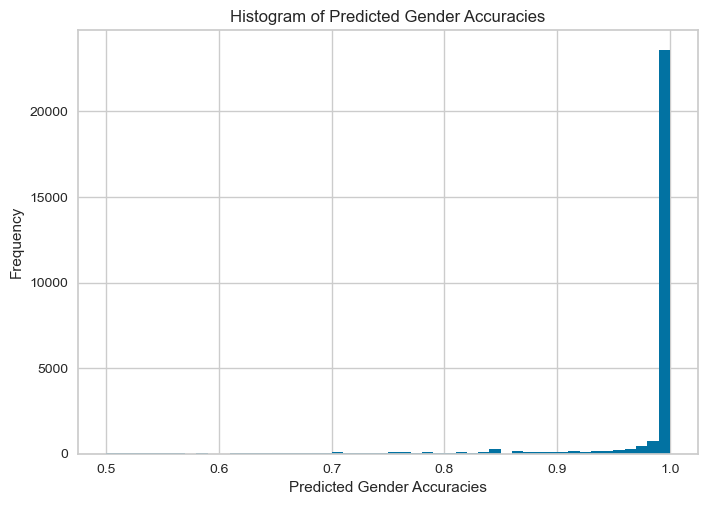

In [72]:
# Histogram of recorded accuracies for each predicted gender
pop_df_complete['Accuracy'].plot.hist(bins=50)
plt.title('Histogram of Predicted Gender Accuracies')
plt.xlabel('Predicted Gender Accuracies')

It's great to see that most of the recorded accuracies are very high. It's also important to remember that these estimated accuracies may not accurately represent how correct the predictions are. One reason for this is that for the nltk classifier, the training data was not very representative of the data that needed predictions.

In [73]:
pop_df_complete[pop_df_complete['Accuracy'] < 0.8].shape[0]/pop_df_complete.shape[0]

0.042636766176260534

In order to ensure that conclusions gathered from this data are more accurate, I will replace the estimated gender with null values for observations with accuracies under 80%. This will only affect around 4% of observations.

In [74]:
pop_df_complete.loc[pop_df_complete['Accuracy'] < 0.8,'Sex at birth'] = ""

Below I will manually correct a few  miss-classifications that I noticed:

In [75]:
pop_df_complete.loc[(pop_df_complete['First Name'] == "Lakshmi") & (pop_df_complete['Last Name'] == "Yatham"),'Sex at birth'] = "Male"
pop_df_complete.loc[(pop_df_complete['First Name'] == "Santa") & (pop_df_complete['Last Name'] == "Ono"),'Sex at birth'] = "Male"
pop_df_complete.loc[(pop_df_complete['First Name'] == "Ali") & (pop_df_complete['Last Name'] == "Lazrak"),'Sex at birth'] = "Male"
pop_df_complete.loc[(pop_df_complete['First Name'] == "Jan") & (pop_df_complete['Last Name'] == "Bena"),'Sex at birth'] = "Female"

Finally, I will export the data to be used to create a Tableau dashboard.

In [76]:
# export dataset
pop_df_complete.to_excel('/Users/jadebouchard/Desktop/UBC Salaries/ubc_salary_deparment_gender_all.xlsx', index = False)

## Data Visualization

Below is a Tableau dashboard showing a visual representation of the data.
The dashboard can also be accessed through this [link](https://public.tableau.com/views/UBCSalary/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link).

- The top left graph is a histogram of salary, stacked by gender.
- The top right graph is a bar chart of median salaries, split by job title and gender
- The bottom left graph is a circle bar chart of median salaries split by gender and department
- The bottom right graph is a side-by-side box plot of salaries, split by department

You can hover over a portion of a plot to get exact values. In addition, you can filter by title and department on the right side of the dashboard.

In [77]:
%%HTML
<div class='tableauPlaceholder' id='viz1700094097675' style='position: relative'><noscript><a href='#'><img alt='Dashboard 1 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;UB&#47;UBCSalary&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='UBCSalary&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;UB&#47;UBCSalary&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1700094097675');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='1120px';vizElement.style.minHeight='587px';vizElement.style.maxHeight='687px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='1120px';vizElement.style.minHeight='587px';vizElement.style.maxHeight='687px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else { vizElement.style.width='100%';vizElement.style.height='1377px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

## Conclusion

In summary, I accomplished my main objective of gaining experience in wrangling data and machine learning. In addition, I was able to visualize the data using an interactive Tableau dashboard. This method of presenting the data seems to be much more user-friendly than the PDF that the University of British Columbia provides.

**Data Analysis**

There are many potential conclusions to be derived from the data presented here. This project stops short at the analysis of the data as the primary objective is to wrangle and visualize the data, which has been accomplished. For future work, an analysis on the statistical significance of salary disparity between genders, titles, and departments would be interesting.

If you are interested in seeing demonstrations of my analysis skills, please check out the following projects on GitHub:
</br>[Forest Fire Impact Prediction Using Linear Regression](https://github.com/jjadeb/Stat_301_Project)
</br>[Impact of Internet Access on Final Grade Using the T-Test](https://github.com/jjadeb/stat-201-project)
</br>[Analysis of Celebrity Age of Death using Stratified Sampling](https://github.com/jjadeb/STAT334-Project)

**Data Limitations**

Any conclusions drawn from the data must take into account the inaccuracies of the department, job title, and gender information. This is partly due to the error involved in clustering and natural language classifiers. In addition, we saw there were many missing data-points for department and title information, therefore the data in the visualization may not accurately represent the entirety of the UBC faculty.

**Final Note**

Overall, this project not only advanced my skills in data manipulation and visualization but also laid the groundwork for future in-depth analyses. I also enhanced my understanding around how data collection and cleaning methods can lead to data limitations, impacting the ability to make meaningful conclusions during analysis.